https://blog.paperspace.com/implement-seq2seq-for-text-summarization-keras/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import json

# Load cornell movie dialog corpus

In [3]:
corpus_df = pd.read_pickle('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/cornell_movie_dialog_corpus/corpus_df.pkl')

In [4]:
corpus_df.head()

,input_seq,output_seq
771777,"[39474, 19939, 7382, 2790, 5272, 19110, 31143]","[26138, 34176, 21944]"
815390,"[55154, 42244, 49176, 55154, 55154]","[26138, 34788, 2589, 10427, 7055, 10427, 2589,..."
718,"[2589, 60732, 2994, 3261, 39474, 19939, 14419,...","[26138, 39342, 44035, 19421, 57062, 31143, 336..."
217598,"[2028, 20218, 31143, 10427, 49373, 56766, 5310...","[26138, 30653, 57927, 52250, 24130, 57062, 380..."
1256845,"[2028, 57062, 31143, 29358, 5112, 32478, 41045]","[26138, 2589, 57062, 38056, 27550, 57062, 3114..."


In [5]:
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/cornell_movie_dialog_corpus/token2index.json', 'r') as f:
    token2index = json.load(f)
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/cornell_movie_dialog_corpus/index2token.json', 'r') as f:
    index2token = json.load(f)

In [6]:
max_index = max(list(token2index.values())) + 1

# Pad sequences

In [7]:
from keras.utils import pad_sequences

2023-09-04 00:06:09.413518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
max_len = 20

In [9]:
input = pad_sequences(corpus_df.input_seq, maxlen = max_len, padding = 'pre')
output = pad_sequences(corpus_df.output_seq, maxlen = max_len + 1, padding = 'post')

In [10]:
input.shape, output.shape

((1507546, 20), (1507546, 21))

# Create model

In [11]:
from keras.utils.vis_utils import plot_model

In [12]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
embedding_dim = 16
latent_dim = 32

In [14]:
embed_layer = Embedding(max_index, embedding_dim, trainable=True)

In [15]:
# Encoder
## Encoder input
encoder_inputs = Input(shape=(max_len, ))
## Embedding layer
encoder_embedded = embed_layer(encoder_inputs)
## Encoder LSTM
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output1, state_h, state_c) = encoder_lstm(encoder_embedded)

# Decoder
## Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(max_len, ))
# Embedding layer
decoder_embedded = embed_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(decoder_embedded, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(max_index, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 16)       991664      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 20, 32),     6272        ['embedding[0][0]']          

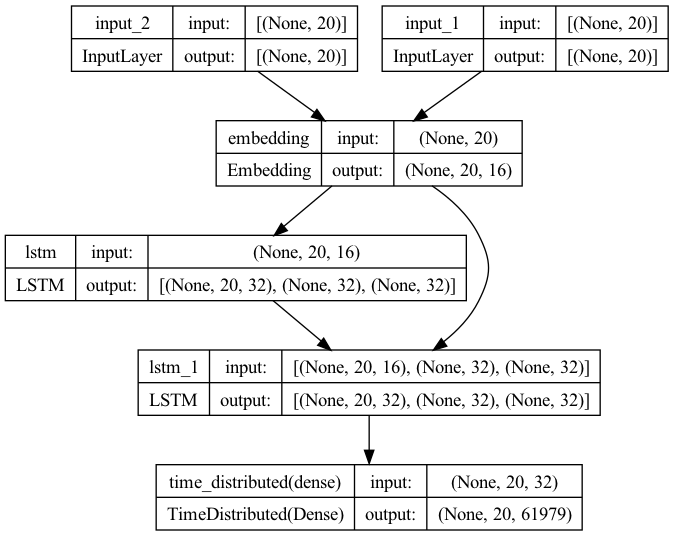

In [16]:
plot_model(model, to_file='model.png', show_shapes=True)

In [17]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [18]:
input.shape

(1507546, 20)

In [19]:
output[:,1:]

array([[34176, 21944,     0, ...,     0,     0,     0],
       [34788,  2589, 10427, ...,     0,     0,     0],
       [39342, 44035, 19421, ...,     0,     0,     0],
       ...,
       [ 2589, 31350, 49250, ...,     0,     0,     0],
       [43279,  5112, 46793, ...,     0,     0,     0],
       [30653, 35324, 21944, ...,     0,     0,     0]], dtype=int32)

In [ ]:
history = model.fit([input, output[:,:-1]],
                    output[:,1:],
                    epochs=10, # callbacks=[es],
                    batch_size=256,
                    validation_freq=0.3)

Epoch 1/10
  30/5889 [..............................] - ETA: 18:26:48 - loss: 10.8941